## Analyze gene expression data for endoderm differentiation dataset

In [1]:
import pandas as pd
import numpy as np

In [2]:
import scipy
import scipy.sparse

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
import sys
sys.path.append('../scripts/')

import settings
from sim_utils import (
    sample_nb
)

In [5]:
from statsmodels.discrete.discrete_model import NegativeBinomial

In [6]:
from joblib import Parallel, delayed

### Functions

In [7]:
def detransform(x):
    """Returns size-factor adjusted CPM counts."""
    return 2**x - 1

def transform(x):
    return np.log2(x+1)

In [8]:
def estimate_nb_params(y, x=None):
    if x is None:
        x = np.ones_like(y)
    model = NegativeBinomial(
        endog=y, 
        exog=x, 
        loglike_method='nb2').fit()
    return model.params, model

### Load data

In [9]:
row_names = pd.read_csv('../data/row_names.csv', index_col=0)
col_names = pd.read_csv('../data/col_names.csv', index_col=0)

In [10]:
log_counts = scipy.sparse.load_npz('../data/log_counts.npz')

In [11]:
endo_pcs = pd.read_csv(settings.ENDO_PCS_PATH, index_col=0).iloc[:, :20]
endo_meta = pd.read_csv(settings.ENDO_META_PATH, sep="\t")

ids = endo_pcs.index.intersection(endo_meta.index)
endo_pcs = endo_pcs.loc[ids]
endo_meta = endo_meta.loc[ids]

In [12]:
log_counts = log_counts[:, col_names.isin(ids).to_numpy().flatten()]

In [13]:
log_counts.shape

(11231, 34256)

### Example gene

1.6540338444120588
4.887815273236805


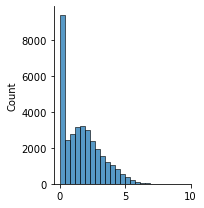

In [53]:
y = log_counts[872, :].A.flatten()
sns.displot(y, height=3, bins=25)
print(y.mean()) # mean on log scale
y = detransform(y).round()
print(y.mean()) # mean on actual scale

In [15]:
(beta, phi), _ = estimate_nb_params(y)
np.exp(beta), beta, phi

Optimization terminated successfully.
         Current function value: 2.541756
         Iterations: 5
         Function evaluations: 8
         Gradient evaluations: 8


(4.8878152732368045, 1.5867454292641652, 2.330191283482928)

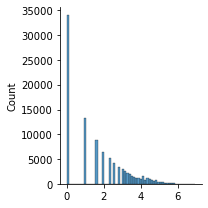

In [16]:
smp = sample_nb(np.exp(beta), phi, random=np.random.default_rng(), size=100000)
sns.displot(transform(smp), height=3);

Estimate as function of environments and individuals

In [17]:
x = pd.concat([endo_pcs, pd.get_dummies(endo_meta['donor_short_id'])], axis=1)
x['offset'] = 1

In [18]:
params, model = estimate_nb_params(y, x=x)

         Current function value: 2.500264
         Iterations: 35
         Function evaluations: 46
         Gradient evaluations: 46


/omics/groups/OE0540/internal/users/heinent/miniconda3/envs/cellregmap/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [19]:
params.loc[['offset', 'alpha']], params.abs().sort_values(ascending=False)[:5]

(offset    1.463432
 alpha     2.094301
 dtype: float64,
 alpha     2.094301
 offset    1.463432
 tavh_2    1.043298
 sohd_3    0.952032
 fasu_2    0.695448
 dtype: float64)

### Visualize statistics for randomly sampled genes

In [20]:
x = pd.concat([endo_pcs, pd.get_dummies(endo_meta['donor_short_id'])], axis=1)
x['offset'] = 1

In [21]:
def est_params(i):
    y = log_counts[i, :].A.flatten()
    y = detransform(y).round()
    params, _ = estimate_nb_params(y, x=x)
    return params.loc[['offset', 'alpha']] 

In [24]:
rng = np.random.default_rng(141)
ids = rng.choice(log_counts.shape[0], 250)

In [ ]:
results = Parallel(n_jobs=25)(delayed(est_params)(i) for i in ids)
results = pd.DataFrame(results)

In [45]:
df = results[results > 0].dropna()

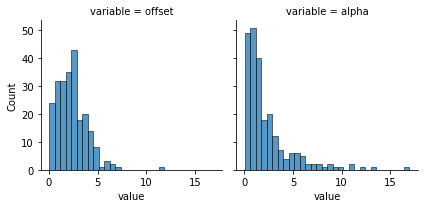

In [46]:
sns.displot(x='value', data=df.melt(), col='variable', height=3)

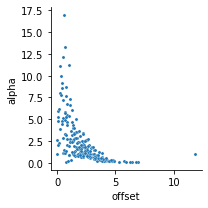

In [47]:
sns.relplot(x='offset', y='alpha', data=df, height=3, s=10)

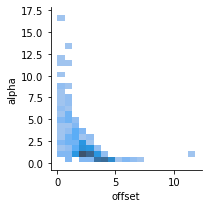

In [52]:
sns.displot(x='offset', y='alpha', data=df, height=3)

In [40]:
df.describe()

,offset,alpha
count,234.000000,234.000000
mean,2.330136,2.235971
std,1.526466,2.531532
min,0.023792,0.050433
25%,1.241533,0.707987
50%,2.196073,1.288366
75%,3.186670,2.739736
max,11.794664,16.966564
